In [583]:
import keras
from keras import layers
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [584]:
y_train.shape

(60000,)

In [585]:
x_train_2d=x_train.reshape((-1,28,28,1))
x_train=x_train.reshape((-1,784))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [586]:
x_train.shape

(60000, 784)

In [587]:
# model=tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(28,28)))
# model.add(tf.keras)
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(10,activation='softmax'))
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy')

In [588]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [589]:
input_img = keras.Input(shape=(784,))
latent=2
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
mu= layers.Dense(latent,activation='relu')(encoded)
sigma= layers.Dense(latent,activation='relu')(encoded)
z = Lambda(sample_z, output_shape=(latent, ), name='z')([mu,sigma])
encoder = keras.Model(input_img,[mu,sigma,z])

decoder_input = layers.Input(shape=(latent,))
decoded = layers.Dense(128,activation='relu')(decoder_input)
outputs = layers.Dense(784, activation='sigmoid')(decoded)
decoder = keras.Model(decoder_input,outputs)
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -0.00005* K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomLayer()([input_img, z_decoded])
vae = Model(input_img, y, name='vae')
vae.compile(optimizer='adam', loss=None)
vae.fit(x_train, None, epochs = 2, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 24s 503us/sample - loss: 0.3864 - val_loss: 0.3664
Epoch 2/2
48000/48000 [==============================] - 16s 342us/sample - loss: 0.3618 - val_loss: 0.3610


In [590]:
# latent=2
# input_img = keras.Input(shape=(28,28,1))
# encoded = layers.Conv2D(32,(3,3))(input_img)
# encoded = layers.Conv2D(16,(3,3))(encoded)
# encoded = layers.Flatten()(encoded)
# encoded = layers.Dense(128, activation='relu')(encoded)
# mu= layers.Dense(latent,activation='relu')(encoded)
# sigma= layers.Dense(latent,activation='relu')(encoded)
# z = Lambda(sample_z, output_shape=(latent, ), name='z')([mu,sigma])
# encoder = keras.Model(input_img,[mu,sigma,z])

# decoder_input = layers.Input(shape=(latent,))
# decoded = layers.Dense(28,activation='relu')(decoder_input)
# outputs = layers.Dense(784, activation='sigmoid')(decoded)
# decoder = keras.Model(decoder_input,outputs)
# z_decoded = decoder(z)

# class CustomLayer(keras.layers.Layer):

#     def vae_loss(self, x, z_decoded):
#         x = K.flatten(x)
#         z_decoded = K.flatten(z_decoded)
        
#         # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
#         recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
#         # KL divergence
#         kl_loss = -5e-6 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
#         return K.mean(recon_loss + kl_loss)

#     # add custom loss to the class
#     def call(self, inputs):
#         x = inputs[0]
#         z_decoded = inputs[1]
#         loss = self.vae_loss(x, z_decoded)
#         self.add_loss(loss, inputs=inputs)
#         return x

# y = CustomLayer()([input_img, z_decoded])
# vae = Model(input_img, y, name='vae')
# vae.compile(optimizer='adam', loss=None)
# vae.fit(x_train_2d, None, epochs = 10, batch_size = 32, validation_split = 0.2)

In [591]:
# autoencoder = keras.Model(input_img, outputs)
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# autoencoder.fit(x_train, x_train,
#                 epochs=5,
#                 shuffle=True,
#                 validation_split=0.2)

# decoder = keras.Model(input)
# encoder.compile(optimizer='adam', loss='mean_squared_error')

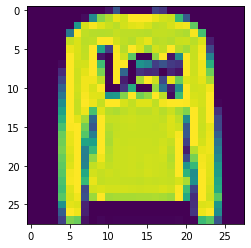

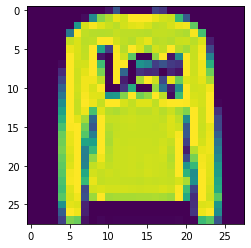

In [592]:
sample=x_test[1]
plt.imshow(sample)
plt.show()
predicted=vae.predict(sample.reshape(-1,784)).reshape((28,28))
plt.imshow(predicted)
plt.show()

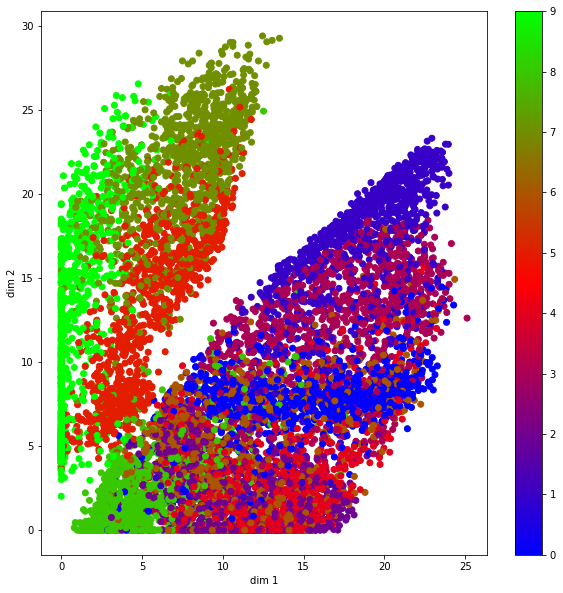

In [593]:
mu, _, _ = encoder.predict(x_test.reshape(-1,784))
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

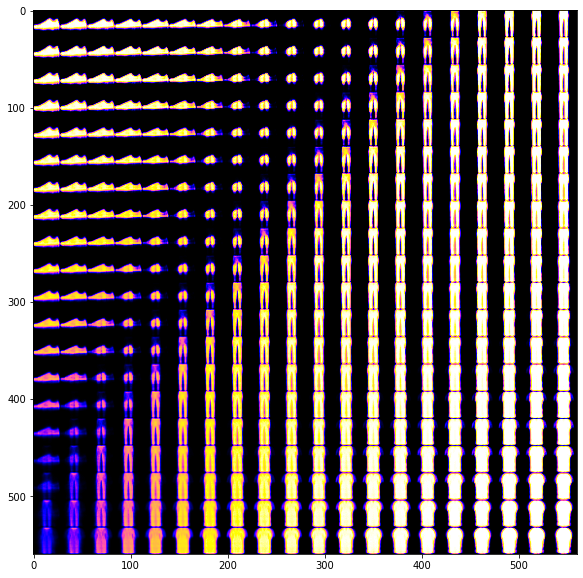

In [594]:
import numpy as np
import random
img_width=28
img_height=28
num_channels=1
n = 20
figure = np.zeros((img_width * n, img_height * n, num_channels))
grid_x = np.linspace(10,60,n)
grid_y = np.linspace(10,60,n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(figure, cmap='gnuplot2')
plt.show() 

In [595]:
# import random
# sample_latent=np.array([[random.random()*5,random.random()*5]])
# n=20
# figure = np.zeros((img_width, img_height*n, num_channels))
# eps=np.linspace(-5, 5, n)
# for i in range(20):
#   changed_vector=np.array([[sample_latent[0][0],sample_latent[0][1]+eps[i]]])
#   x_decoded = decoder.predict(changed_vector)
#   fashion = x_decoded[0].reshape(img_width, img_height, num_channels)
#   figure[:img_width, i*img_height:(i+1)*img_height] = fashion
# plt.figure(figsize=(10, 10))
# fig_shape = np.shape(figure)
# figure = figure.reshape((fig_shape[0], fig_shape[1]))
# plt.imshow(figure, cmap='gnuplot2')
# plt.show() 